In [1]:
import sys; sys.path.append('../rrr')
import decoy_mnist
from multilayer_perceptron import *
from figure_grid import *
from local_linear_explanation import *
import random
import numpy as np
import matplotlib.pyplot as plt

# Decoy MNIST

This is a version of MNIST augmented with color splotches that correspond to the digits in the training set but not the test set. These color splotches are a "decoy rule" the model could inappropriately learn and try to apply to the test set, similar to the Husky vs. Wolf problem in [LIME](https://arxiv.org/abs/1602.04938).

Let's see if we can fool the perceptron but then help it correct its mistake.

In [52]:
Xr, X, y, E, Xtr, Xt, yt, Et = decoy_mnist.generate_dataset(cachefile='../data/decoy-mnist.npz')
Xr = np.array([x.ravel() for x in Xr])
Xtr = np.array([x.ravel() for x in Xtr])

Let's visualize our dataset first:

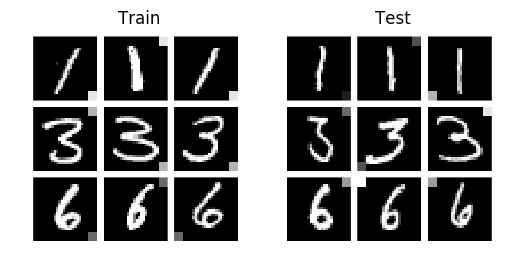

In [53]:
def examples_matching(digits, X, y):
  return X[np.array([list(np.argwhere(y==d).T[0][167:230]) for d in digits]).T.ravel()]

plt.subplot(121)
plt.title('Train')
image_grid(examples_matching([1,3,6], X, y), (28,28), 3)
plt.subplot(122)
plt.title('Test')
image_grid(examples_matching([1,3,6], Xt, yt), (28,28), 3)
plt.show()

Note that all training examples have the same splotch color for each digit, and all test examples have randomly colored splotches. We'll train three models: an MLP on the decoy set normally, an MLP on the decoy set with annotations to help it generalize, and an MLP on the actual MNIST dataset.

In [4]:
mlp_normal = MultilayerPerceptron()
mlp_normal.fit(X, y)
print(mlp_normal.score(X, y))
print(mlp_normal.score(Xt, yt))

0.997083333333
0.5481


In [6]:
mlp_annotated = MultilayerPerceptron(l2_grads=1000)
mlp_annotated.fit(X, y, E)
print(mlp_annotated.score(X, y))
print(mlp_annotated.score(Xt, yt))

0.989416666667
0.9631


In [7]:
mlp_nondecoy = MultilayerPerceptron()
mlp_nondecoy.fit(Xr, y)
print(mlp_nondecoy.score(Xtr, yt))
print(mlp_nondecoy.score(Xr, y))

0.9578
0.9847


In [9]:
test_scores = [mlp_normal.score(Xt, yt), mlp_annotated.score(Xt, yt), mlp_nondecoy.score(Xtr, yt)]
model_names = ['$A=0$', 'full $A$', 'Baseline']

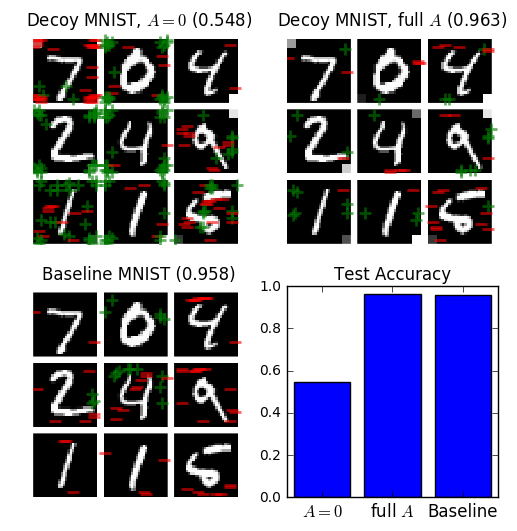

In [45]:
def explain(model, title='', length=3, i=0, Xt=Xt, **kwargs):
  plt.title(title)
  explanation_grid(model.grad_explain(Xt[i:i+length*length]), (28,28), length, **kwargs)

plt.figure(figsize=(6,6))
plt.subplot(221)
explain(mlp_normal, 'Decoy MNIST, $A=0$ ({:.3f})'.format(test_scores[0]))
plt.subplot(222)
explain(mlp_annotated, 'Decoy MNIST, full $A$ ({:.3f})'.format(test_scores[1]))
plt.subplot(223)
explain(mlp_nondecoy, 'Baseline MNIST ({:.3f})'.format(test_scores[2]), Xt=Xtr)

plt.subplot(224)
plt.title('Test Accuracy')
plt.bar(np.arange(len(test_scores))+0.1, test_scores)
plt.gca().set_xticks([0.5,1.5,2.5])
plt.gca().set_xticklabels(model_names, fontsize=12)
plt.xlim(0,3)
plt.ylim(0,1)

plt.show()

It looks like the decoy model focuses many of its input gradients on the corners, but the baseline model and the model trained to ignore the corners both achieve high test accuracy.

## Comparison with LIME

Let's see how LIME does compared to gradients -- although it may not be a fair comparison, because this is using `lime_tabular`, which isn't optimized or really meant for images at all.

In [10]:
import time

t1 = time.clock()
lime_explanations = mlp_normal.lime_explain(Xt[:9])
t2 = time.clock()
grad_explanations = mlp_normal.input_gradients(Xt[:9])
t3 = time.clock()

print('LIME for 9 examples took {:.5f}s/example'.format((t2-t1)/9.))
print('grads for 9 examples took {:.5f}s/example, which is {:.0f}x faster'.format((t3-t2)/9., (t2-t1)/float(t3-t2)))

/Users/asross/.pyenv/versions/3.5.1/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


LIME for 9 examples took 12.69249s/example
grads for 9 examples took 0.00055s/example, which is 23049x faster


In [49]:
np.sum(e.coefs.sum() for e in lime_explanations)

0.0

Looking at the actual coefficients, it actually seems like `lime_tabular` applied to MNIST images doesn't really work, in part because the way it perturbs inputs in the tabular case, which I believe is just by adding Gaussian noise, may be insufficient to really change predictions at all. So it's really not a fair comparison.

## Find-another-explanation

The training procedure is implemented in a separate script in `bin`, but let's analyze its results here:

In [16]:
import pickle
fae_1000s = [MultilayerPerceptron.from_params(p)
             for p in pickle.load(open('../data/decoy_mnist_fae_1000', 'rb'))]
fae_10000s = [MultilayerPerceptron.from_params(p)
             for p in pickle.load(open('../data/decoy_mnist_fae_10000', 'rb'))]
fae_100000s = [MultilayerPerceptron.from_params(p)
             for p in pickle.load(open('../data/decoy_mnist_fae_100000', 'rb'))]

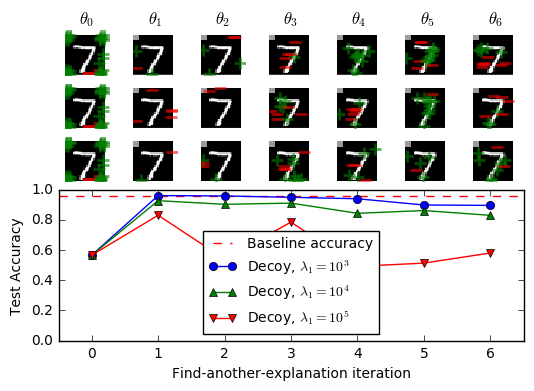

In [51]:
def accs(faes):
  return [fae.score(Xt,yt) for fae in faes]

gridsize = (6,7)
example = 0

for i in range(7):
  plt.subplot2grid(gridsize, (0,i))
  explain(fae_1000s[i], r'$\theta_{}$'.format(i), 1, i=example)
  
for i in range(7):
  plt.subplot2grid(gridsize, (1,i))
  explain(fae_10000s[i], '', 1, i=example)
  
for i in range(7):
  plt.subplot2grid(gridsize, (2,i))
  explain(fae_100000s[i], '', 1, i=example)
  
plt.subplot2grid(gridsize, (3,0), rowspan=3, colspan=7)
plt.axhline(mlp_nondecoy.score(Xtr, yt), color='red', ls='--', label='Baseline accuracy')
plt.plot(list(range(len(fae_1000s))), accs(fae_1000s), marker='o', label=r'Decoy, $\lambda_1=10^3$', c='blue')
plt.plot(list(range(len(fae_10000s))), accs(fae_10000s), marker='^', label=r'Decoy, $\lambda_1=10^4$', c='green')
plt.plot(list(range(len(fae_100000s))), accs(fae_100000s), marker='v', label=r'Decoy, $\lambda_1=10^5$', c='red')
plt.legend(loc='best', fontsize=10)
plt.xlim(-0.5, 6.5)
plt.ylim(0.0, 1)
plt.xlabel(r'Find-another-explanation iteration')
plt.ylabel('Test Accuracy')
  
plt.show()

We can see that test accuracy increases after the first iteration, then slowly trends downward, possibly because we are biasing the model against considering the most significant elements of each image. For high $\lambda_1$, this happens much more abruptly, and even after just one iteration accuracy isn't quite back to ideal, perhaps because the original model did still consider some important components.

## Investigating cutoffs

Let's also just interrogate our arbitrary choice of cutoff slightly:

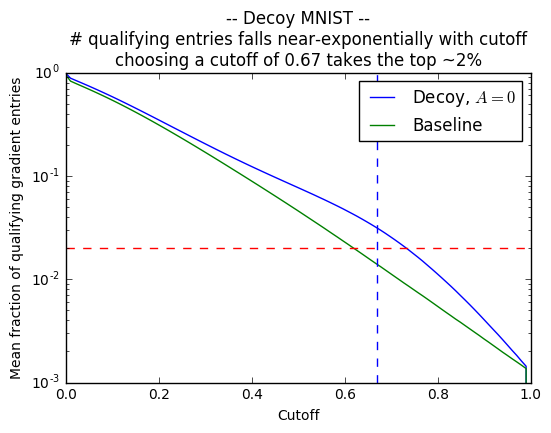

In [29]:
def M(input_gradients, cutoff=0.67):
  return np.array([np.abs(e) > cutoff*np.abs(e).max() for e in input_gradients]).astype(int).ravel()

grads = mlp_normal.input_gradients(Xt)

cutoffs = np.linspace(0,1,100)
cutoff_pcts = np.array([M(grads, c).sum() / float(len(grads.ravel())) for c in cutoffs])

grads2 = mlp_nondecoy.input_gradients(Xtr)
cutoff_pcts2 = np.array([M(grads2, c).sum() / float(len(grads2.ravel())) for c in cutoffs])

plt.plot(cutoffs, cutoff_pcts, label='Decoy, $A=0$')
plt.plot(cutoffs, cutoff_pcts2, label='Baseline')
plt.legend(loc='best')
plt.xlabel('Cutoff')
plt.ylabel('Mean fraction of qualifying gradient entries')
plt.yticks(np.linspace(0,1,21))
plt.axhline(0.02, ls='--', c='red')
plt.axvline(0.67, ls='--', c='blue')
plt.yscale('log')
plt.title('-- Decoy MNIST --\n# qualifying entries falls near-exponentially with cutoff\nchoosing a cutoff of 0.67 takes the top ~2%')
plt.show()

Here there does appear to be a bit of a kink in the curve at least for the decoy model, and it's about at where we chose our cutoff.